In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Any, Dict, List, Optional, Tuple

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import nolds
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import entropy
from sklearn.impute import KNNImputer

from utils import (
    MIN_VALUE_THRESHOLD,
    NAN_THRESHOLD,
    AdjacencyMethod,
    DistanceTransformation,
    EventData,
    GraphEvent,
    Normalizer,
    load_events,
    # setup_plotting,
)

# setup_plotting()


## Preprocess DataFrames

Somes events have 2-min resolution (we downloaded them for 1-min though), so we decided to standardize all events to 2-min. And, apparently, the data cannot have any NaN value, so I'll try to input data

In [3]:
def invalid_stations(station_df: pd.DataFrame, use_threshold: bool) -> List[str]:
    """Check if a station has less than NAN_THRESHOLD percentage of NaN values."""
    nan_ratios = station_df.isna().mean()

    if use_threshold:
        invalid_stations = nan_ratios[nan_ratios >= NAN_THRESHOLD].index.tolist()
    else:
        invalid_stations = nan_ratios[nan_ratios > 0].index.tolist()

    return invalid_stations

In [4]:
events = load_events()

# Fill data preprocessing
for event_name, data in events.items():
    df = data["raw"]

    # Drop stations with too many NaNs
    stations_to_drop = invalid_stations(df, use_threshold=True)
    df = df.drop(columns=stations_to_drop)

    # Impute missing values using KNN Imputer
    imputer = KNNImputer(n_neighbors=2, weights="uniform")
    df.loc[:, :] = imputer.fit_transform(df)

    # Resample to 2-minute intervals using median
    events[event_name]["raw"] = df.resample("5min").median()

    print(f"Event {event_name}: Dropped stations {stations_to_drop}")

Event 2023-04-23: Dropped stations ['CALM', 'JBGO']
Event 2024-03-24: Dropped stations []
Event 2024-05-10: Dropped stations ['IRK2', 'JBGO']
Event 2002-04-17: Dropped stations ['DRBS']
Event 2003-10-29: Dropped stations ['DRBS']
Event 2003-11-20: Dropped stations ['DRBS']
Event 2004-11-09: Dropped stations ['DRBS']
Event 2005-01-21: Dropped stations ['DRBS']
Event 2005-05-14: Dropped stations ['DRBS']
Event 2005-08-24: Dropped stations ['DRBS']
Event 2005-09-10: Dropped stations ['ATHN', 'DRBS']
Event 2006-12-14: Dropped stations ['DRBS']
Event 2011-10-24: Dropped stations []
Event 2012-03-08: Dropped stations []
Event 2012-07-14: Dropped stations ['ESOI']
Event 2015-06-22: Dropped stations []
Event 2017-09-07: Dropped stations []
Event 2021-11-03: Dropped stations []


## Create Graphs & Compare normalization methods

Based on [001_tests_with_graphs.ipynb](./001_tests_with_graphs.ipynb), the best methods are: `MANHATTAN` & `MINKOWSKI`, so I'll be using only those. The data will be previously normalized with diferents methods in order to compare.

A new kind of graph is calculated, the "count" is not used to construct the adjacency matrix, now the matrix is calculated using the percentual change: $x_{i\%} = \frac{x_{i} - x_{i-1}}{x_{i-1}}$. When $i = 0$, $x_{i\%} = 0$; when $x_{i-1} = 0$, is replaced to `MIN_VALUE_THRESHOLD` (1e-16). This new data it's calculated when there isn't a normalization method.

In [39]:
# Función para calcular la dimensión fractal (Método de Box-counting)
def calcular_dimension_fractal(imagen):
    # Convertir la imagen a escala de grises y binarizarla
    # imagen_gray = imagen.convert("L")
    pixels = np.array(imagen)
    pixels = (pixels > np.mean(pixels)).astype(int)  # Binarizar la imagen

    # Tamaños de los "cajas" que se utilizarán para el conteo
    sizes = []
    counts = []

    for size in range(2, min(pixels.shape) // 2):
        count = 0
        # Contar cuántas "cajas" de tamaño `size` contienen píxeles blancos
        for i in range(0, pixels.shape[0], size):
            for j in range(0, pixels.shape[1], size):
                if np.any(pixels[i : i + size, j : j + size] == 1):
                    count += 1
        sizes.append(size)
        counts.append(count)

    # Calcular la dimensión fractal
    sizes = np.array(sizes)
    counts = np.array(counts)

    # Calcular la pendiente de la regresión log-log
    log_sizes = np.log(sizes)
    log_counts = np.log(counts)
    coef = np.polyfit(log_sizes, log_counts, 1)  # Regresión lineal
    dimension_fractal = -coef[0]  # La pendiente es la dimensión fractal
    return dimension_fractal, log_sizes, log_counts


# Función para calcular la entropía de una imagen
def calcular_entropia(imagen):
    # Convertir la imagen a escala de grises
    # imagen_gray = imagen.convert('L')
    # Obtener los píxeles de la imagen
    pixels = np.array(imagen)
    
    # Normalizar la imagen entre 0 y 1
    hist, bins = np.histogram(pixels.flatten(), bins=256, range=(0, 256))
    hist = hist / hist.sum()  # Normalizar histograma
    
    # Calcular la entropía
    entropia = -np.sum(hist * np.log2(hist + 1e-6))  # Sumar sobre el histograma normalizado
    return entropia



In [40]:
valid_methods = (AdjacencyMethod.MANHATTAN, AdjacencyMethod.MINKOWSKI)

In [ ]:
def calc_graph_metrics(
    events: Dict[str, EventData],
    *,
    transform_method: DistanceTransformation = DistanceTransformation.NONE,
    threshold: float = 0.0,
) -> Tuple[pd.DataFrame, List[Dict[str, Any]]]:
    dataset = []

    # 4 nested loops... damn
    for event_date, data in events.items():
        for method in valid_methods:
            for normalization in Normalizer:
                raw_df = data["raw"].reset_index(drop=True)

                # Transform raw_df data before any normalization
                transformed_data = transform_method.transform(raw_df.to_numpy())
                transformed_df = pd.DataFrame(transformed_data, columns=raw_df.columns)

                # Normalize data
                columns = transformed_df.columns
                normalized_data = normalization.normalize(transformed_df.to_numpy())
                normalized_df = pd.DataFrame(normalized_data, columns=columns)

                # Replace all zeros with a small value to avoid issues in pct_change (infinite values)
                normalized_df[normalized_df.abs() < MIN_VALUE_THRESHOLD] = (
                    MIN_VALUE_THRESHOLD
                )

                # Generate graph
                # FIXME: This is temporal, I gotta refactor
                for df, label in (
                    (normalized_df, "normal"),
                ):
                    thresholded_df = df.copy()
                    if threshold > 0.0:
                        thresholded_df[df.abs() > threshold] = MIN_VALUE_THRESHOLD

                    graph_event = GraphEvent(
                        data=thresholded_df,
                        metadata={
                            # Event metadata
                            "drop": data.get("drop", 0.0),
                            "intensity": data.get("intensity", "Unknown"),
                            "dst": data.get("dst", 0.0),
                            # Station metadata
                            "cutoff_rigidity": data["cutoff_rigidity"],
                            "altitude": data["altitude"],
                        },
                    )

                    try:
                        graph = graph_event.get_graph_networkx(method)
                    except Exception:
                        print("Processing event:", event_date)
                        print("Using method:", method.value)
                        print("Using normalization:", normalization.value)

                        print("\nraw_df snapshot:")
                        display(raw_df.head())

                        print("transformed_df snapshot:")
                        display(transformed_df.head())

                        print("normalized_df snapshot:")
                        display(normalized_df.head())

                        print("Final normalized_df snapshot:")
                        display(normalized_df.head())

                        raise

                    # Calculate MST and store it
                    graph = nx.minimum_spanning_tree(graph)
                    events[event_date]["graphs"][method] = graph

                    # Degree distribution in order to calculate other metrics
                    degree = graph.degree()
                    degree = list(map(lambda x: x[1], degree))
                    degree_distribution = np.array(degree) / sum(degree)

                    # Global graph metrics
                    dataset.append(
                        {
                            "event_date": event_date,

                            # Event metadata
                            "drop": data.get("drop", 0.0),
                            "intensity": data.get("intensity", "Unknown"),
                            "dst": data.get("dst", 0.0),

                            # Metric metadata
                            "normalization": normalization.value,
                            "adjacency_method": method.value,
                            "data_label": label,
                            "graph": graph,
                            # "diameter": (
                            #     nx.diameter(graph)
                            #     if nx.is_connected(graph)
                            #     else float("inf")
                            # ),
                            # "radius": (
                            #     nx.radius(graph)
                            #     if nx.is_connected(graph)
                            #     else float("inf")
                            # ),
                            "global_efficiency": nx.global_efficiency(graph),
                            "entropy": calcular_entropia(normalized_data),
                            "fractal": calcular_dimension_fractal(normalized_data)[0],
                            "hurst_rs": nolds.hurst_rs(degree_distribution, fit="poly"),
                            "modularity": nx.algorithms.community.modularity(
                                graph,
                                list(
                                    nx.algorithms.community.greedy_modularity_communities(
                                        graph
                                    )
                                ),
                            ),
                            "assortativity": nx.degree_assortativity_coefficient(graph),
                        }
                    )

    dataset_df = pd.DataFrame(dataset)
    return dataset_df, dataset

In [46]:
transform_method = DistanceTransformation.EXPONENTIAL
dataset_df, dataset = calc_graph_metrics(events, transform_method=transform_method)

In [62]:
dataset_df.drop(columns=["graph"]).to_csv("dataset.csv")

In [61]:
import statsmodels.api as sm

df0 = dataset_df[
    (dataset_df["normalization"] == "z_score")
    & (dataset_df["adjacency_method"] == "manhattan")
    & (dataset_df["data_label"] == "normal")
].sort_values(by="intensity")[
    [
        "global_efficiency",
        "entropy",
        # "hurst_rs",
        # "fractal",
        # "modularity",
        "assortativity",
        "intensity",
    ]
]

x0 = df0.drop(columns=["intensity"]).astype(float).values
y =  df0["intensity"].replace(
        ["G1", "G2", "G3", "G4", "G5", "Unknown", np.nan], [1, 2, 3, 4, 5, 0, 0]
    ).astype(float).values

x0 = sm.add_constant(x0)  # Adds a constant term to the predictor
model = sm.OLS(y, x0).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     5.997
Date:                Fri, 06 Feb 2026   Prob (F-statistic):            0.00758
Time:                        14:26:20   Log-Likelihood:                -27.298
No. Observations:                  18   AIC:                             62.60
Df Residuals:                      14   BIC:                             66.16
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.4547      2.965      5.213      0.0

In [25]:
y

array(['G2', 'G3', 'G3', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4',
       'G5', 'G5', 'G5', 'G5', 'Unknown', 'Unknown', nan], dtype=object)

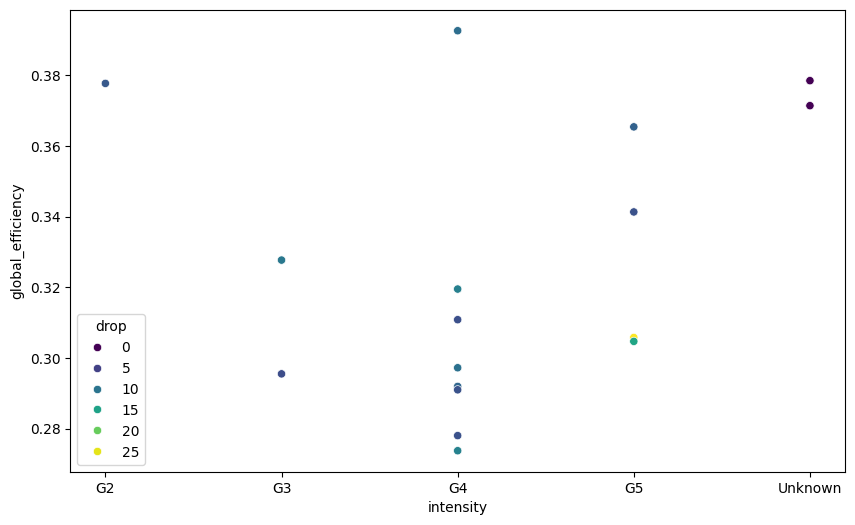

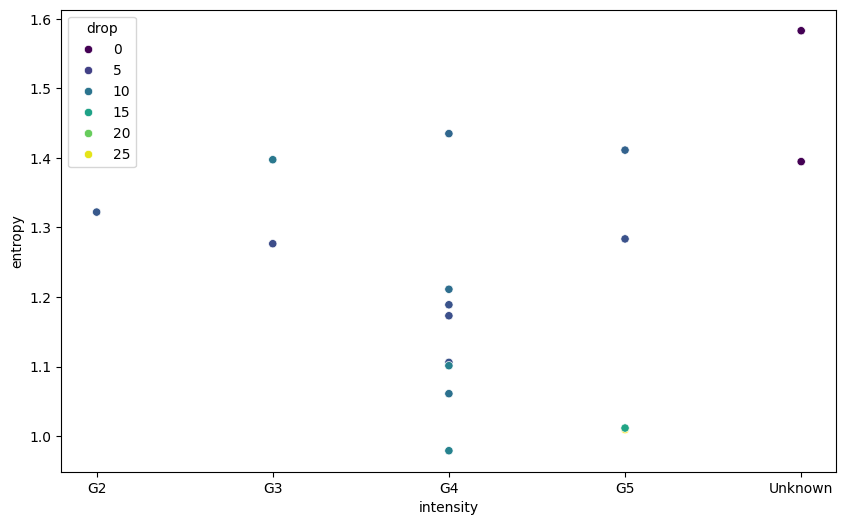

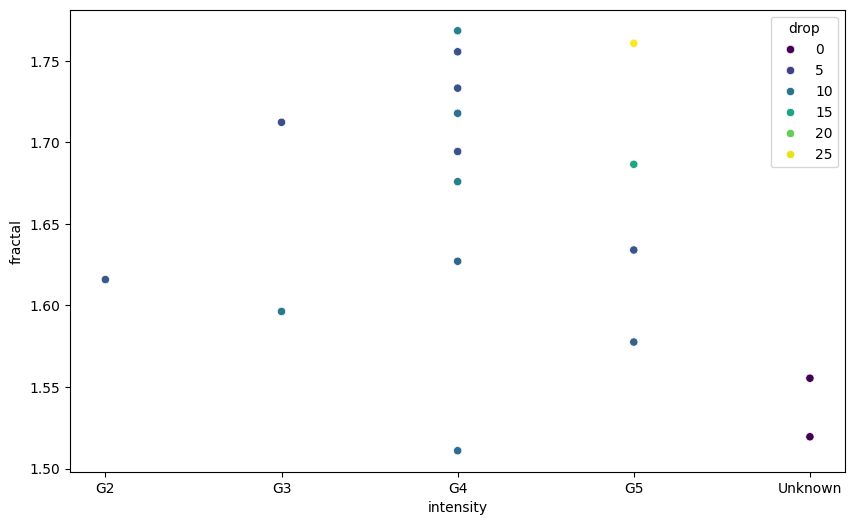

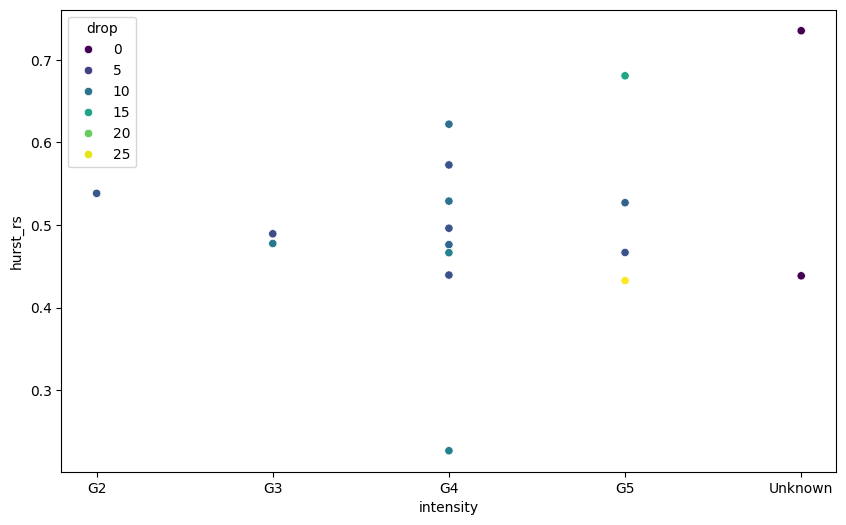

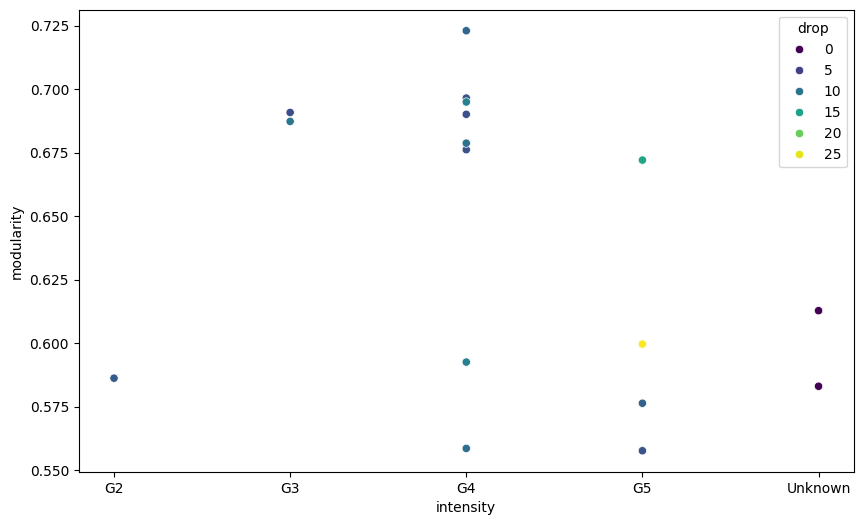

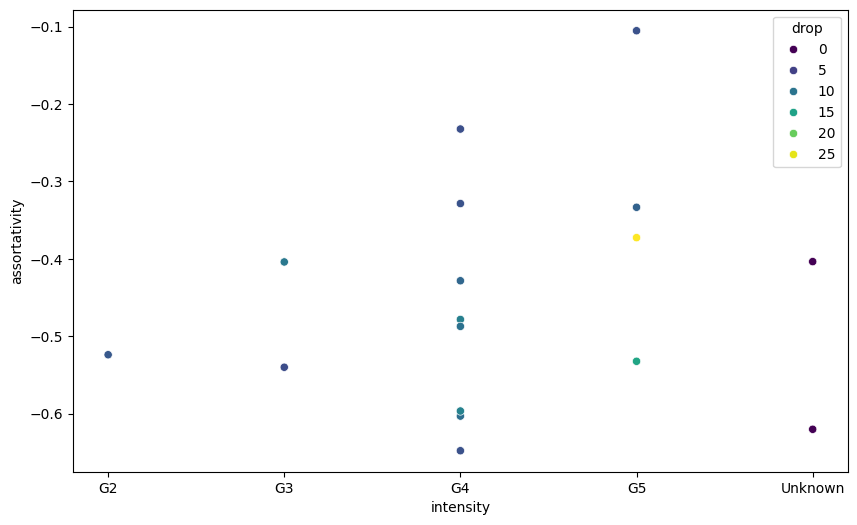

In [49]:
for metric in ["global_efficiency", "entropy", "fractal", "hurst_rs", "modularity", "assortativity"]:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=dataset_df[
            (dataset_df["normalization"] == "z_score")
            & (dataset_df["adjacency_method"] == "manhattan")
            & (dataset_df["data_label"] == "normal")
        ].sort_values("intensity"),
        x="intensity",
        y=metric,
        hue="drop",
        # style="normalization",
        palette="viridis",
    )

### Plot global metrics

Percentual change is calculated, but based on the results, is not as good as expected, so I'll ignore it meanwhile

In [53]:
def plot_global_metrics_result(
    plot_dataset_df: pd.DataFrame, fig_title: str = ""
) -> None:
    unique_events = plot_dataset_df["event_date"].unique()
    normalization_methods = plot_dataset_df["normalization"].unique()

    nrows = len(unique_events)
    ncols = len(normalization_methods)

    fig, axes = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        figsize=(ncols * 5.5, nrows * 4),
    )

    axes = axes.flatten()
    i = 0
    for event_date in unique_events:
        for norm_method in normalization_methods:
            plot_data = plot_dataset_df[
                (plot_dataset_df["event_date"] == event_date)
                & (plot_dataset_df["normalization"] == norm_method)
            ]

            intensity = plot_data["intensity"].values[0]

            ax = axes[i]
            i += 1
            sns.barplot(
                data=plot_data,
                x="metric",
                y="value",
                hue="adjacency_method",
                ax=ax,
            )

            # Add value labels on bars
            for container in ax.containers:
                ax.bar_label(container, fmt="%.2f", color="black", fontsize=8)

            ax.set_title(
                (
                    f"Event Date: {event_date} -- Intensity: {intensity} --"
                    f"\n Norm: {norm_method} -- Drop: {plot_data['drop'].values[0]}"
                )
            )
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")

    fig.tight_layout()
    if fig_title:
        fig.suptitle(fig_title, fontsize=16)

    plt.show()

In [54]:
transform_method = DistanceTransformation.EXPONENTIAL
dataset_df, dataset = calc_graph_metrics(events, transform_method=transform_method)

metrics_columns = [
    # "diameter",
    # "radius",
    "global_efficiency",
    "entropy",
    "fractal",
    "hurst_rs",
    "modularity",
    "assortativity",
]
id_vars = [
    "event_date",
    "intensity",
    "drop",
    "dst",
    "adjacency_method",
    "normalization",
    "data_label",
]

dataset_copy_df = pd.DataFrame(dataset).drop(columns=["graph"])
plot_dataset_df = dataset_copy_df.melt(
    id_vars=id_vars,
    value_vars=metrics_columns,
    var_name="metric",
    value_name="value",
)

In [55]:
plot_dataset_df[
    (plot_dataset_df["data_label"] == "normal")
    & ~(plot_dataset_df["intensity"].isna())
    & (plot_dataset_df["intensity"] != "Unknown")
]

,event_date,intensity,drop,dst,adjacency_method,normalization,data_label,metric,value
0,2023-04-23,G4,6.57,-213.0,manhattan,min_max,normal,global_efficiency,0.254586
1,2023-04-23,G4,6.57,-213.0,manhattan,z_score,normal,global_efficiency,0.278017
2,2023-04-23,G4,6.57,-213.0,manhattan,robust,normal,global_efficiency,0.295047
3,2023-04-23,G4,6.57,-213.0,manhattan,decimal_scaling,normal,global_efficiency,0.298222
4,2023-04-23,G4,6.57,-213.0,manhattan,none,normal,global_efficiency,0.298222
...,...,...,...,...,...,...,...,...,...
1075,2021-11-03,G4,9.68,-117.0,minkowski,min_max,normal,assortativity,-0.401095
1076,2021-11-03,G4,9.68,-117.0,minkowski,z_score,normal,assortativity,-0.542010
1077,2021-11-03,G4,9.68,-117.0,minkowski,robust,normal,assortativity,-0.327721
1078,2021-11-03,G4,9.68,-117.0,minkowski,decimal_scaling,normal,assortativity,-0.282051


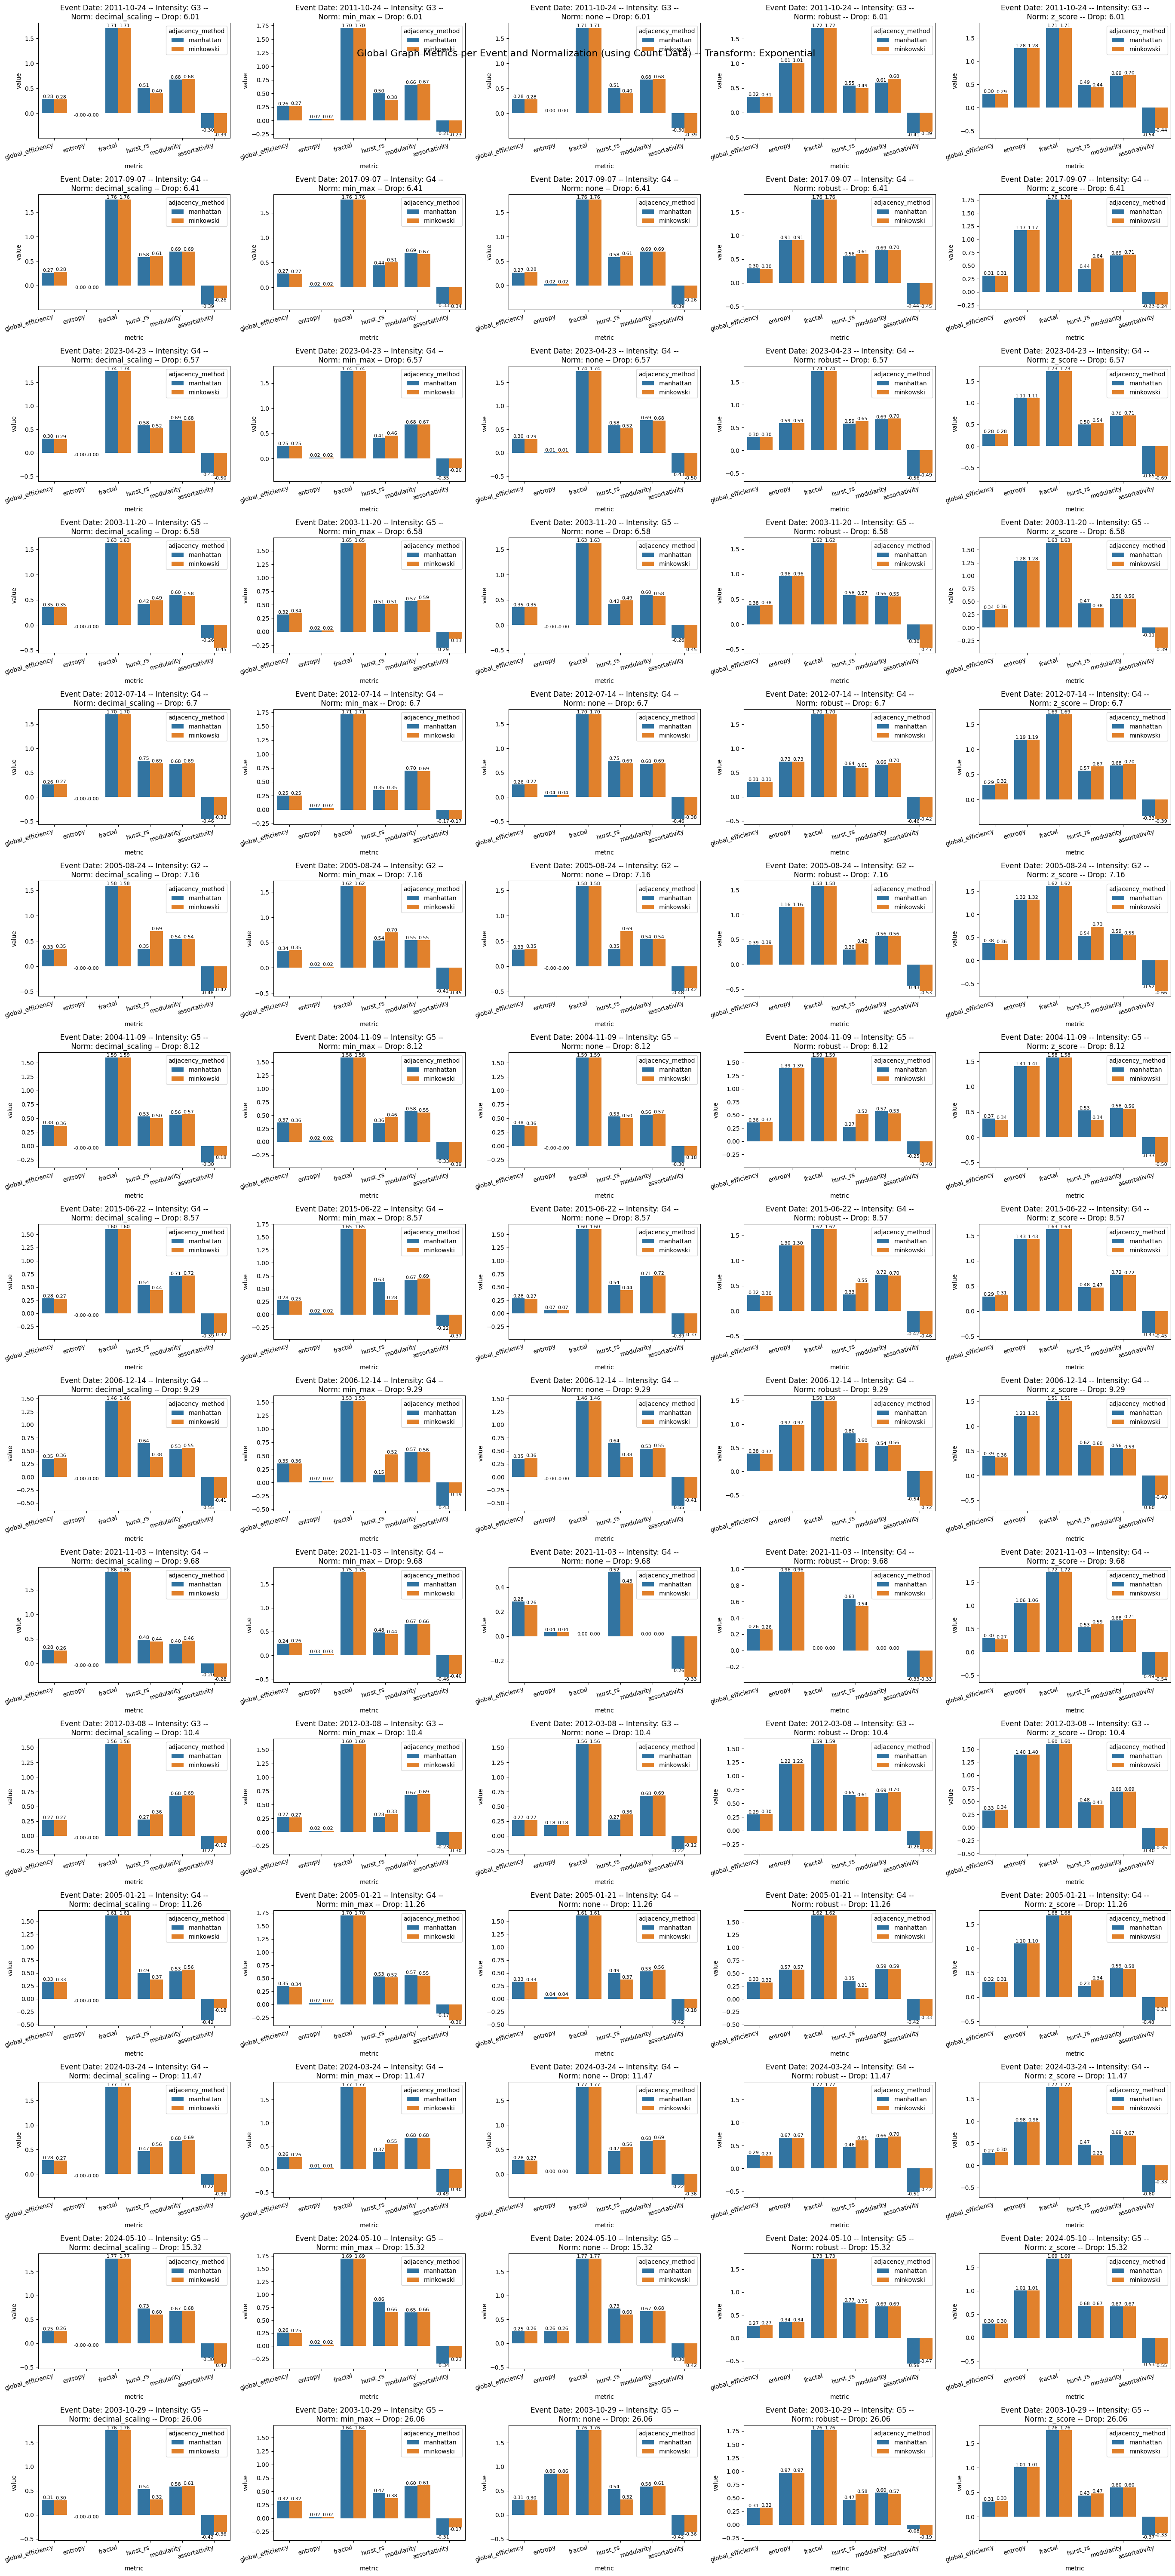

In [ ]:
plot_global_metrics_result(
    plot_dataset_df[
        (plot_dataset_df["data_label"] == "normal")
        & ~(plot_dataset_df["intensity"].isna())
        & (plot_dataset_df["intensity"] != "Unknown")
    ].sort_values(by=["drop", "intensity", "normalization"]),
    # fig_title=(
    #     "Global Graph Metrics per Event and Normalization (using Count Data) -- "
    #     f"Transform: {transform_method.value.title()}"
    # ),
)

### Plot graphs

I'm using only Z-Score, but it's just an example, could be interchangeable

In [58]:
def plot_graphs_result(
    df: pd.DataFrame,
    title: str = "",
    *,
    altitude_normalizer: Normalizer = Normalizer.NONE,
    fixed_node_size: Optional[float] = None,
) -> None:
    cmap = plt.cm.viridis  # type: ignore

    unique_events = df["event_date"].unique()
    adjacency_methods = df["adjacency_method"].unique()

    nrows = len(unique_events)
    ncols = len(adjacency_methods)

    fig, axes = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        figsize=(ncols * 10.5, nrows * 4),
    )

    axes = axes.flatten()
    i = 0
    for event_date in unique_events:
        for adj_method in adjacency_methods:
            plot_data = df[
                (df["event_date"] == event_date)
                & (df["adjacency_method"] == adj_method)
            ]

            intensity = plot_data["intensity"].values[0]
            graph = plot_data["graph"].values[0]
            cutoff = graph.graph["metadata_cutoff_rigidity"]
            altitudes = graph.graph["metadata_altitude"]

            ax = axes[i]
            i += 1

            if fixed_node_size is None:
                node_sizes = np.array([altitudes[n] for n in graph.nodes()])
                node_sizes = altitude_normalizer.normalize(node_sizes)
                if altitude_normalizer != Normalizer.NONE:
                    node_sizes = 300 + (node_sizes - np.min(node_sizes)) * 700

                node_sizes = node_sizes.tolist()
            else:
                node_sizes = fixed_node_size

            pos = nx.spring_layout(graph, weight="weight", seed=42)
            nodes = list(graph.nodes())
            vals = np.array([cutoff.get(n, np.nan) for n in nodes], dtype=float)

            if np.all(np.isnan(vals)):
                nx.draw(
                    graph,
                    pos,
                    ax=ax,
                    with_labels=True,
                    node_size=node_sizes,
                    font_size=9,
                    font_color="black",
                    node_color="red",
                    edge_color="gray",
                )
            else:
                vmin = np.nanmin(vals)
                vmax = np.nanmax(vals)
                norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)  # type: ignore

                nx.draw_networkx_nodes(
                    graph,
                    pos,
                    nodelist=nodes,
                    node_color=vals,
                    cmap=cmap,
                    node_size=node_sizes,
                    ax=ax,
                )
                nx.draw_networkx_labels(graph, pos, font_size=9, ax=ax)
                nx.draw_networkx_edges(graph, pos, edge_color="gray", ax=ax)

                sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)  # type: ignore
                sm.set_array([])
                cbar = plt.colorbar(sm, ax=ax)
                cbar.set_label("Cutoff rigidity")

            ax.set_title(
                (
                    f"Event Date: {event_date} -- Intensity: {intensity} -- "
                    f"Norm: {adj_method.title()}"
                )
            )

    if title:
        fig.suptitle(title, fontsize=16)

    fig.tight_layout()
    plt.show()

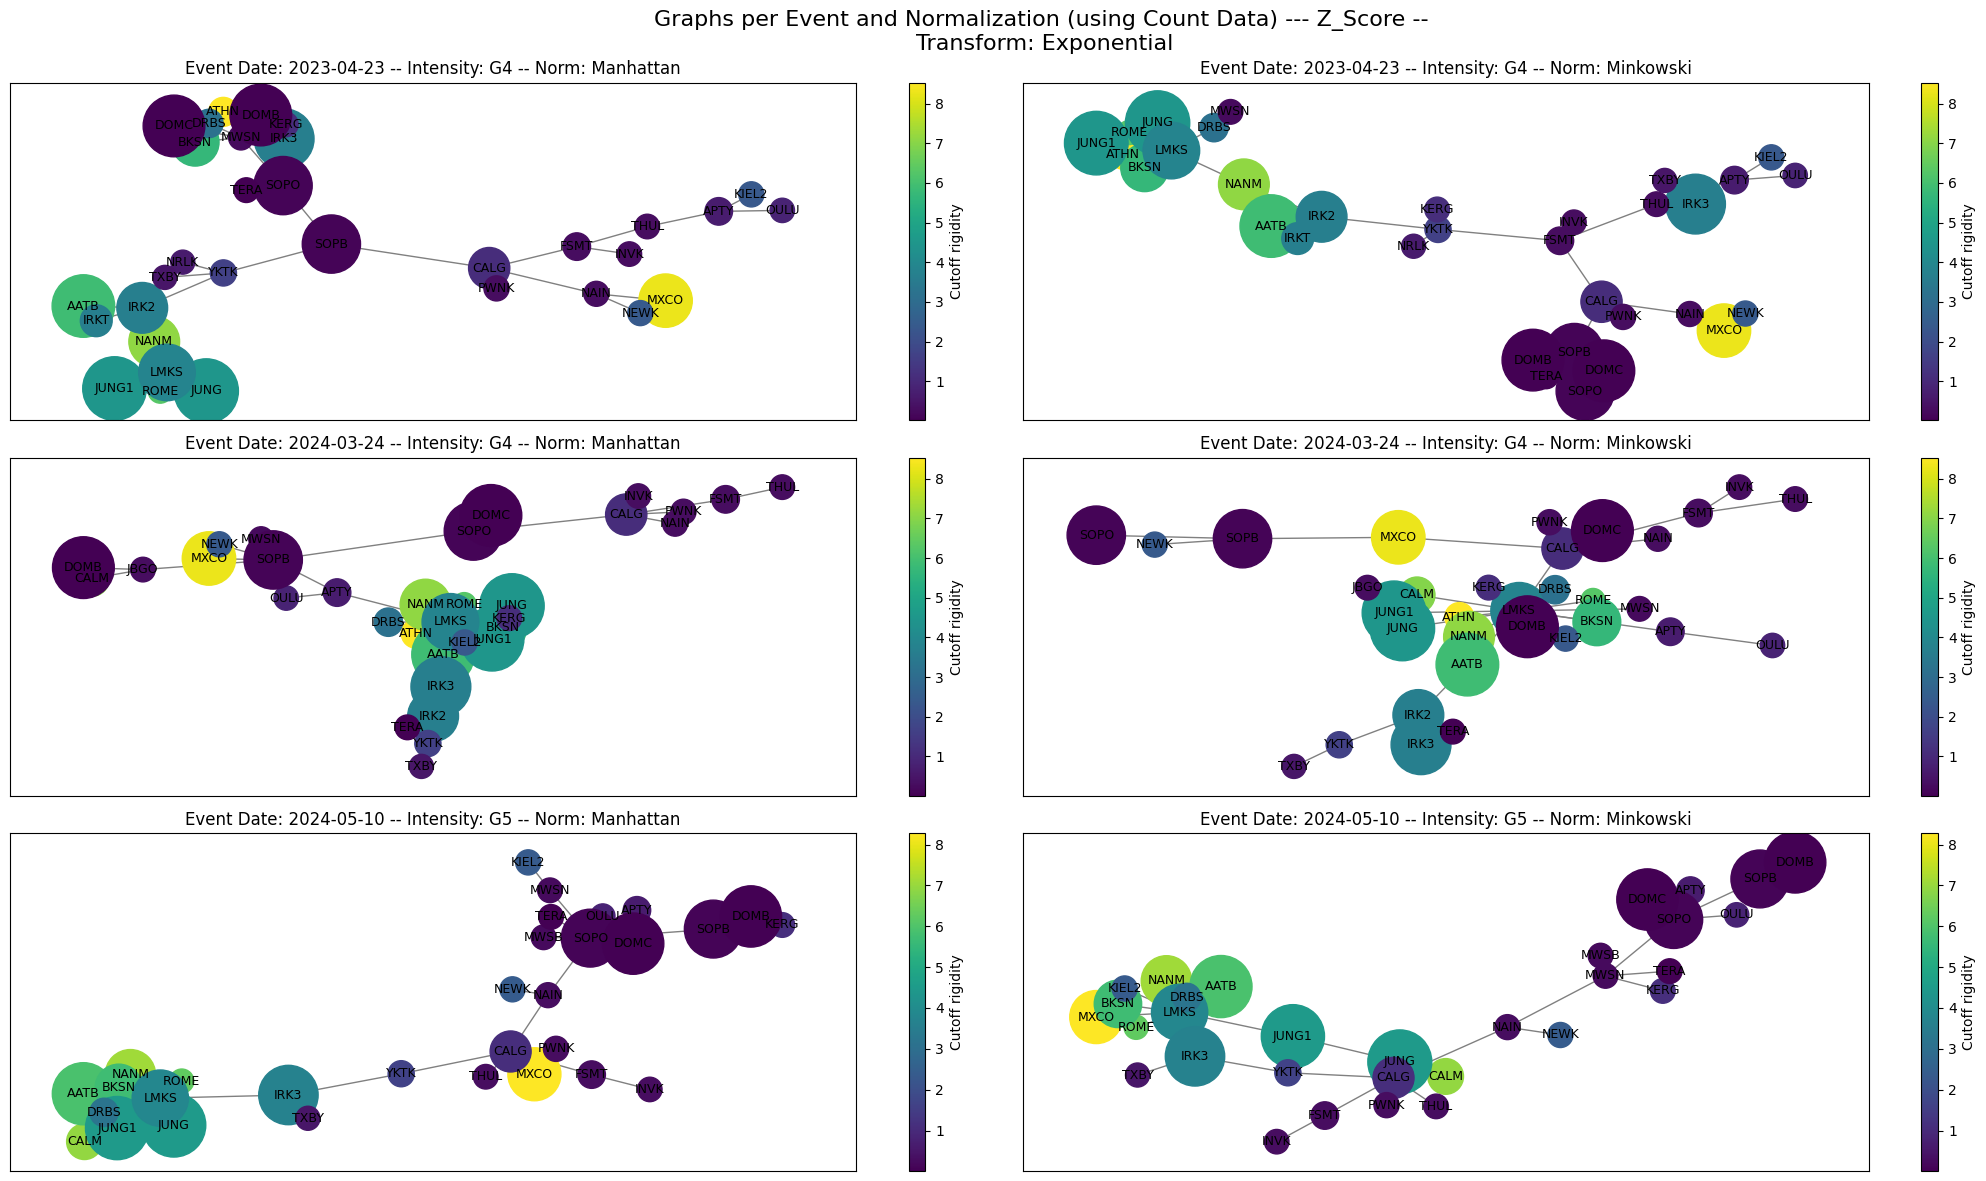

In [65]:
transform_method = DistanceTransformation.EXPONENTIAL
dataset_df, dataset = calc_graph_metrics(
    events, transform_method=transform_method, threshold=0
)

normalization_method = Normalizer.Z_SCORE

plot_graphs_result(
    dataset_df[
        (dataset_df["data_label"] == "normal")
        & (dataset_df["normalization"] == normalization_method.value)
    ],
    (
        f"Graphs per Event and Normalization (using Count Data) --- {normalization_method.value.title()} -- "
        f"\nTransform: {transform_method.value.title()}"
    ),
    altitude_normalizer=Normalizer.Z_SCORE,
)

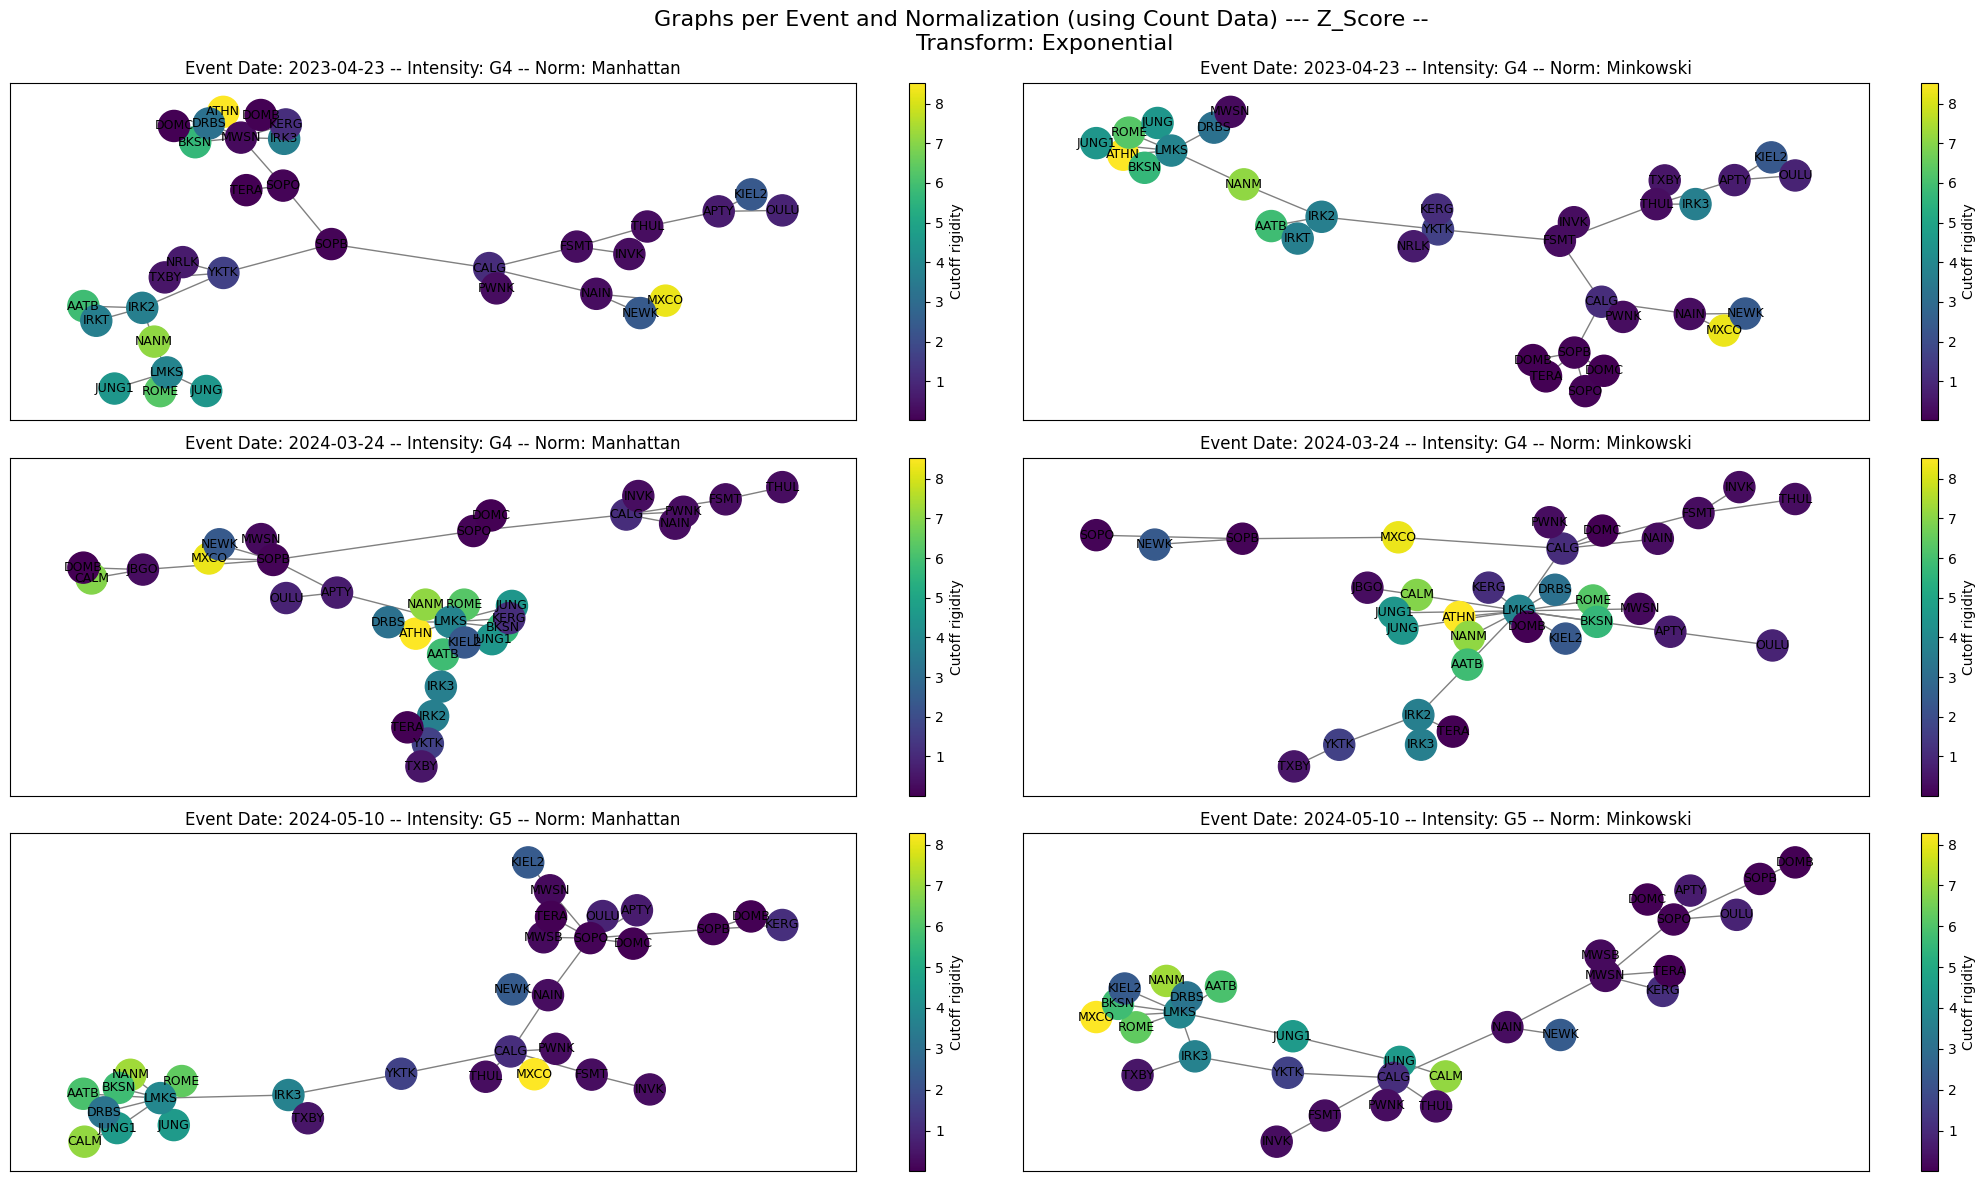

In [66]:
transform_method = DistanceTransformation.EXPONENTIAL
dataset_df, dataset = calc_graph_metrics(
    events, transform_method=transform_method, threshold=0
)

normalization_method = Normalizer.Z_SCORE

plot_graphs_result(
    dataset_df[
        (dataset_df["data_label"] == "normal")
        & (dataset_df["normalization"] == normalization_method.value)
    ],
    (
        f"Graphs per Event and Normalization (using Count Data) --- {normalization_method.value.title()} -- "
        f"\nTransform: {transform_method.value.title()}"
    ),
    fixed_node_size=500,
)